<a href="https://colab.research.google.com/github/yoavram/MarineML/blob/main/computervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📷 Session 3: The AI Field Ecologist
**Objective:** Automate the census of marine animals from drone/field imagery.

**The Problem:**
Counting animals manually takes days. We want to do it in seconds.

**The Pipeline:**
1.  **The Spotter - [MegaDetector](https://megadetector.readthedocs.io/):** A model trained on millions of camera trap images to find "Animals" (bounding boxes).
2.  **The Taxonomist - [BioCLIP](https://imageomics.github.io/bioclip/):** A foundation model that knows the taxonomy of 450,000 species. It looks at the box and says "That's a *Phoca vitulina*".

This code installs the libraries and defines the helper functions.

In [1]:
# @title ⚙️ Setup & Engine (Run this once)
print("Installing libraries... (this takes ~1 min)")
!pip install PytorchWildlife open_clip_torch matplotlib requests supervision lightning --quiet

Installing libraries... (this takes ~1 min)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [29]:
# @title Import libraries
%matplotlib inline
import torch
import numpy as np
import requests
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from collections import Counter
import open_clip
from PytorchWildlife.models import detection as pw_detection
import matplotlib.pyplot as plt

In [5]:
# @title Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [6]:
# @title 2. Load The Spotter (MegaDetector v5)
print("Loading MegaDetector v5...")
detector = pw_detection.MegaDetectorV5(device=device, pretrained=True)

Loading MegaDetector v5...


Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


In [64]:
# @title 3. Load The Taxonomist (BioCLIP)
print("Loading BioCLIP...")
bioclip_model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')
bioclip_model.to(device)

def infer_species(img, species_list):
  text_inputs = tokenizer(species_list).to(device)
  image_input = preprocess(img).unsqueeze(0).to(device)
  with torch.no_grad():
      image_features = bioclip_model.encode_image(image_input)
      text_features = bioclip_model.encode_text(text_inputs)
      # Normalize
      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features /= text_features.norm(dim=-1, keepdim=True)
      # Probability
      text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

  # Get winner
  top_prob, top_idx = text_probs.cpu().topk(1, dim=-1)
  return species_list[top_idx], top_prob


Loading BioCLIP...


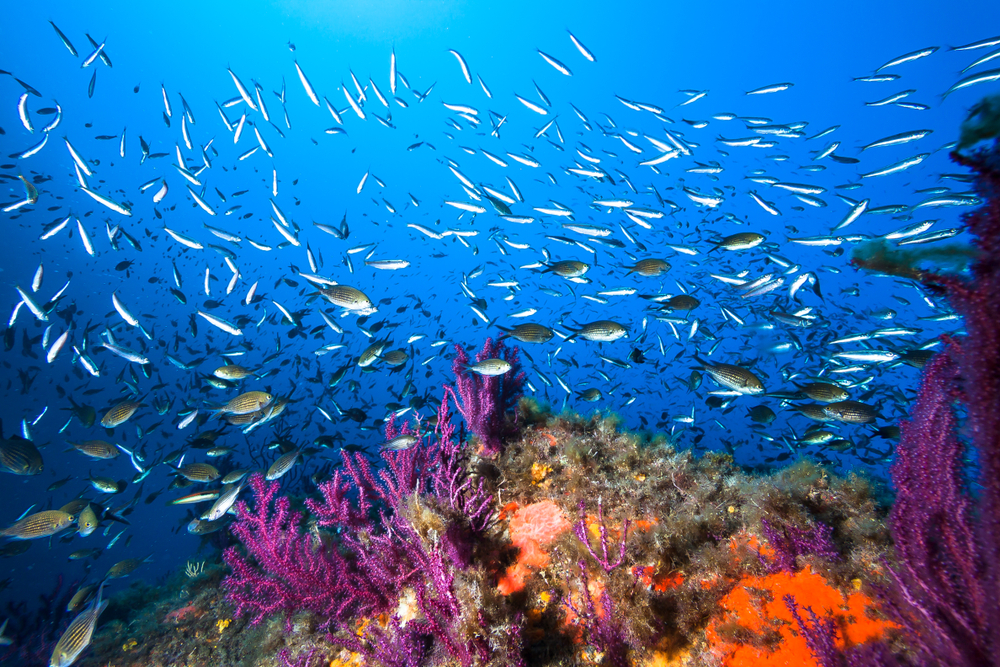

In [82]:
# Option A
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Steller_sea_lions_leveled.jpg/1280px-Steller_sea_lions_leveled.jpg"

# Option B
image_url = "https://upload.wikimedia.org/wikipedia/commons/0/07/Emperor_Penguin_Manchot_empereur.jpg"

# Option C
image_url = "https://i.pinimg.com/originals/c1/cc/80/c1cc8019c992aad46e09a43122656eac.jpg"

# Option D:
# image_url = 'https://70milesofcoast.com/wp-content/uploads/2021/09/2009-Harbor-Seals.jpg'
# image_url = 'https://70milesofcoast.com/wp-content/uploads/2021/09/Harbor-Seals-Childrens-Pool-3-1536x1152.jpg'

# Option E
image_url = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fjourneyz.co%2Fwp-content%2Fuploads%2F2021%2F08%2FMost-Beautiful-Mediterranean-Sea-Animals.jpg&f=1&nofb=1&ipt=4c77470dffc7447fcdae7099012426aeefb8e9504037f173e2440767546dabce'

response = requests.get(image_url, headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
})
assert response.status_code == 200, "Failed to download image"
img = Image.open(BytesIO(response.content)).convert("RGB")
img

In [85]:
# @title Detect with MegaDetector
results = detector.single_image_detection(np.array(img), det_conf_thres=0.1)
detections = results['detections']
print(f"🔎 Found {len(detections)} animals.")

🔎 Found 15 animals.


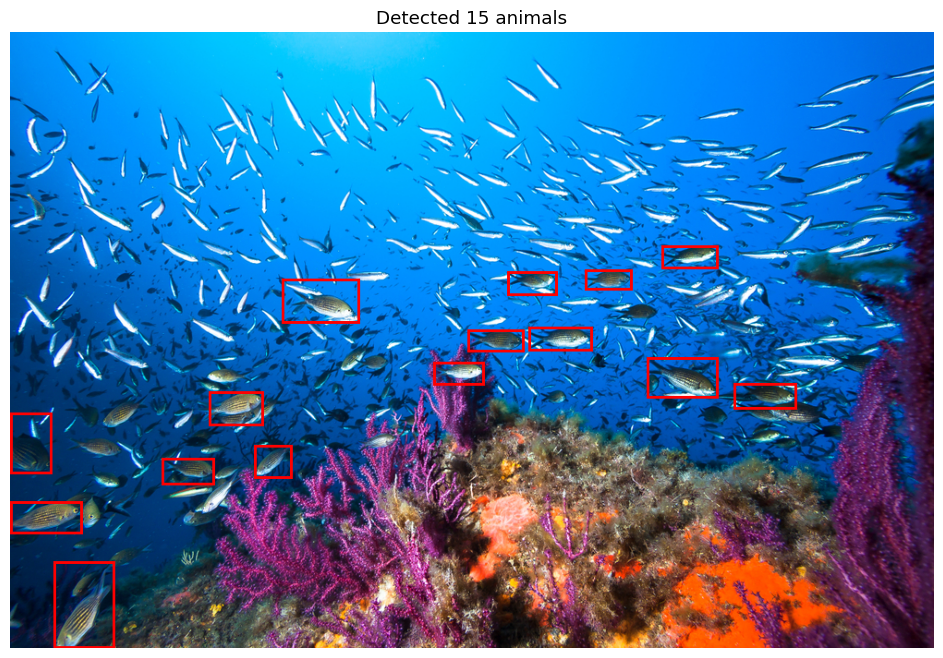

In [86]:
img_with_boxes = img.copy()
draw = ImageDraw.Draw(img_with_boxes)

for det in detections:
    x1, y1, x2, y2 = det[0]
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

plt.figure(figsize=(12, 8))
plt.imshow(img_with_boxes)
plt.axis('off')
plt.title(f"Detected {len(detections)} animals")
plt.show()

In [92]:
# Prepare text for BioCLIP
species_list = [
    "Steller Sea Lion",
    "Harbor Seal",
    "California Sea Lion",
    # "Larus (Gull)",
    # "Emperor_Penguin",
    "Killer whale",
    "Tail",
    "Rock",
    "Fish"
]
counts = Counter()

# C. Classify (BioCLIP) loop
for det in detections:
    x1, y1, x2, y2 = det[0]
    # Crop the animal
    crop = img.crop((x1, y1, x2, y2))
    # BioCLIP Inference
    species, prob = infer_species(crop, species_list)
    print(f"{species}:\t{prob.item():.1%}")
    counts[species] += 1

for species, count in counts.items():
    print(f"{species}: {count}")

Fish:	99.1%
Fish:	85.8%
Fish:	62.6%
Fish:	97.8%
Fish:	80.8%
Fish:	94.6%
Killer whale:	49.8%
Killer whale:	85.7%
Fish:	88.8%
Fish:	87.9%
Fish:	98.5%
Fish:	96.9%
Fish:	94.8%
Fish:	96.3%
Fish:	91.9%
Fish: 13
Killer whale: 2
